In [1]:
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
import seaborn as sns

import urllib.request
import os

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect, \
                                        GetMACCSKeysFingerprint
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog

In [2]:
def similarity(fps):
    sim = []
    for ind_i, fg in enumerate(fps):
        sim.append([])
        for ind_j in range(0, ind_i + 1):
            if ind_i != ind_j:
                sim[ind_i].append(DataStructs.TanimotoSimilarity(fps[ind_i],fps[ind_j]))
            else:
                sim[ind_i].append(0)
    return sim

In [3]:
def intersection(fps):
    intersec = []
    for ind_i, fg in enumerate(fps):
        intersec.append([])
        for ind_j in range(0, ind_i + 1):
            if ind_i != ind_j:
                andfp = fps[ind_i]&fps[ind_j]
                obl = list(andfp.GetOnBits())
                obls = [fcat.GetEntryDescription(item) for item in obl]
                intersec[ind_i].append(obls)
            else:
                intersec[ind_i].append([])
    return intersec

In [4]:
def mol_drawer(sim_func, fps, l_mol_objs, n):
    sim = sim_func(fps) #counting similarity scores
    """
    Creating a list of tuples with simularity /
        score and indexes of molecules in i_mol_objs

    """
    max_sim = []
    for i in range(len(sim)):
        max_sim.append((sim[i][np.argmax(sim[i])],i,np.argmax(sim[i])))
    max_sim = sorted(max_sim)
    """
    Extracting 4 pairs of most similar molecules / 
         from sorted l_mol_objs according to their /
             similarity score to be visialized

    """
    out = []
    for i in range(n):
        out.append(l_mol_objs[max_sim[len(max_sim)-1-i][1]])
        out.append(l_mol_objs[int(max_sim[len(max_sim)-1-i][2])])
        print(max_sim[len(max_sim)-1-i])
    return max_sim, Draw.MolsToGridImage(out, molsPerRow=2)

In [5]:
def request(cids):
    molecules = []
    for cid in cids:
        if cid != '_':
            url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + str(cid) + '/property/CanonicalSMILES/csv'
            response = urllib.request.urlopen(url)
            molecules.append(response.read().decode('utf-8'))
    list_of_molecules = []
    for ind, mol in enumerate(molecules):
        a = mol.split(sep='"')
        molecules[ind] = a[5]
        list_of_molecules.append([chemicals['name'][ind], int(a[4][1:-1]), a[5]])
    return molecules, list_of_molecules

In [6]:
chemicals = pd.read_csv("direct_reprogramming_non-genetics.csv")
chemicals

cid                                               link  \
0      459803   https://pubchem.ncbi.nlm.nih.gov/compound/459803   
1    91899426  https://pubchem.ncbi.nlm.nih.gov/compound/9189...   
2      286003   https://pubchem.ncbi.nlm.nih.gov/compound/286003   
3       47289    https://pubchem.ncbi.nlm.nih.gov/compound/47289   
4      451668   https://pubchem.ncbi.nlm.nih.gov/compound/451668   
..        ...                                                ...   
153   2814138  https://pubchem.ncbi.nlm.nih.gov/compound/2814138   
154   5282411  https://pubchem.ncbi.nlm.nih.gov/compound/5282411   
155  10202642  https://pubchem.ncbi.nlm.nih.gov/compound/1020...   
156   6437836  https://pubchem.ncbi.nlm.nih.gov/compound/6437836   
157      1613     https://pubchem.ncbi.nlm.nih.gov/compound/1613   

                                               name  \
0                                          AC1LA18U   
1                         2-phospho-L-ascorbic acid   
2                                    DTXSID80301486   
3    4-(Methylnitrosamino)-1-(3-pyridyl)-1-butanone   
4                            5-Aza-2'-deoxycytidine   
..                                              ...   
153                                            OAC2   
154                                Prostaglandin I2   
155                                        GW788388   
156                                      Peretinoin   
157                                     Zopolrestat   

                                              Synonyms  \
0                                                  NaN   
1                  2-phospho-L-ascorbic acid;BDBM92477   
2                                                  NaN   
3                                                  NaN   
4    Decitabine;5-Aza-2'-deoxycytidine;2353-33-5;Da...   
..                                                 ...   
153                                                NaN   
154                                                NaN   
155                                                NaN   
156                                                NaN   
157                                                NaN   

                                                   MOA  
0            Inhibitor of the HIF prolyl 4-hydroxylase  
1                                                    _  
2                    Agonist of the Adenosine Receptor  
3                                                    _  
4                         Inhibitor of DNA methylation  
..                                                 ...  
153                                                  _  
154  Activator of prostaglandin receptors EP1, EP2,...  
155  Inhibitor of Transforming Growth Factor Beta S...  
156            Agonist of retinoid acid receptor (RAR)  
157      Inhibitor of carboxylic acid aldose reductase  

[158 rows x 5 columns]

In [7]:
cids = chemicals['cid']
molecules, list_of_molecules = request(cids)

In [8]:
molecules

['C1=CC2=C(C3=C(C=C2)C(=O)C(=CN3)C(=O)O)N=C1',
 'C(C(C1=C(C(=C(O1)O)OP(=O)([O-])[O-])[O-])O)O',
 'CC1(OC2C(O1)C(OC2C(=O)O)N3C=NC4=C(N=CN=C43)N)C',
 'CN(CCCC(=O)C1=CN=CC=C1)N=O',
 'C1C(C(OC1N2C=NC(=NC2=O)N)CO)O',
 'CC1=NC(=CC=C1)C2=NN(C=C2C3=CC=NC4=CC=CC=C34)C(=S)NC5=CC=CC=C5',
 'C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CO)O)O)N',
 'COC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=CC=C3)Cl)OC',
 'CC1(CCC(C2=C1C=CC(=C2)C(=O)NC3=CC=C(C=C3)C(=O)O)(C)C)C',
 'C1=CC=C2C(=C1)C(=O)OC23C4=CC(=C(C(=C4OC5=C(C(=C(C=C35)Br)[O-])Br)Br)[O-])Br.[Na+].[Na+]',
 'C1=CC=C2C(=C1)C=CC(=C2C=NNC(=O)C3=CC=NC=C3)O',
 'CC1=CC(=NN1)NC2=C(C=C(C(=N2)NC(C)C3=CC=C(C=C3)F)C#N)F',
 'CC1=C(C(C(=C(N1)C)[N+](=O)[O-])C2=CC=CC=C2C(F)(F)F)C(=O)OC',
 'CC1=CC2=C(C=C1C(=C)C3=CC=C(C=C3)C(=O)O)C(CCC2(C)C)(C)C',
 'C1=CC=C2C(=C1)C(=C(N2)C3=C(NC4=C3C=CC(=C4)Br)O)N=O',
 'CN1CCCN(CC1)C2=NC3=CC(=C(C=C3C(=N2)NC4CCN(CC4)CC5=CC=CC=C5)OC)OC',
 'CCC1=C(N(N=N1)CC)SCC2=C(N3C(C(C3=O)NC(=O)CS(=O)C4=CC=CS4)SC2)C(=O)O',
 'C1=CC=C(C=C1)CCNC2=C3C4=CC=CC=C4C(=O)C5=C3C(=CC=

In [9]:
l_mol_objs = [Chem.MolFromSmiles(molecule) for molecule in molecules]

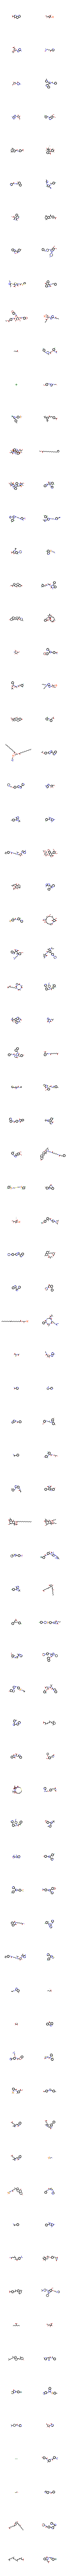

In [10]:
Draw.MolsToGridImage(l_mol_objs, molsPerRow=2)

In [11]:
fps = [GetMorganFingerprintAsBitVect(molecule, 2) for molecule in l_mol_objs]

In [12]:
sim = similarity(fps)

In [13]:
max_sim, pictures = mol_drawer(similarity, fps, l_mol_objs, 4)

(1.0, 132, 86)
(1.0, 128, 126)
(0.8888888888888888, 113, 39)
(0.8, 91, 90)


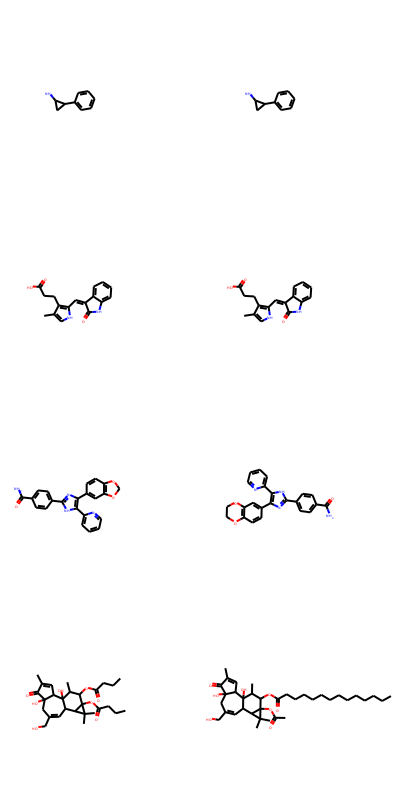

In [14]:
pictures

In [15]:
print(list_of_molecules[126][1], list_of_molecules[128][1])

5289418 5289418


In [16]:
fName=os.path.join(RDConfig.RDDataDir,'FunctionalGroups.txt')
fparams = FragmentCatalog.FragCatParams(1,6,fName)
fparams.GetNumFuncGroups()

fcat=FragmentCatalog.FragCatalog(fparams)
fcgen=FragmentCatalog.FragCatGenerator()

3

In [17]:
for molecule in l_mol_objs: 
    nAdded=fcgen.AddFragsFromMol(molecule,fcat)
print(fcat.GetNumEntries())
fcat.GetEntryDescription(523)

19766


'c<-N>cncnc'

In [18]:
fpgen = FragmentCatalog.FragFPGenerator()
frag_fps = [fpgen.GetFPForMol(molecule,fcat) for molecule in l_mol_objs]

In [19]:
intersections = intersection(frag_fps)
intersections

[[[]],
 [[], []],
 [['cc', 'c[nH]', 'ccn', 'c[nH]c', 'ccnc', '[nH]ccn', 'c[nH]ccn', 'cncc[nH]c'],
  [],
  []],
 [['cc',
   'c[nH]',
   'ccc',
   'ccn',
   'c[nH]c',
   'cccc',
   'cccn',
   'ccnc',
   'ccccc',
   'ccccn',
   'cccnc',
   'ccncc',
   'cccccn',
   'ccccnc',
   'cccncc',
   'c1ccncc1'],
  [],
  ['cc', 'c[nH]', 'ccn', 'c[nH]c', 'ccnc', 'CC', 'CCC'],
  []],
 [['c[nH]'],
  [],
  ['c[nH]',
   'CC',
   'CO',
   'Cn',
   'c<-N>n',
   'CCO',
   'COC',
   'CCn',
   'nCO',
   'cnC',
   'ncn',
   'c<-N>nc',
   'CCOC',
   'cnCC',
   'CC(n)O',
   'cnCO',
   'Cncn',
   'c<-N>ncn',
   'CCncn',
   'cnC(C)O',
   'ncnCO',
   'CC(O)ncn'],
  ['c[nH]', 'CC'],
  []],
 [['cc',
   'c[nH]',
   'ccc',
   'ccn',
   'c[nH]c',
   'cccc',
   'cccn',
   'cc(c)c',
   'ccnc',
   'cc(c)n',
   'ccccc',
   'ccc(c)c',
   'ccccn',
   'cccnc',
   'cc(c)cn',
   'ccc(c)n',
   'ccncc',
   'cnc(c)c',
   'cccccc',
   'ccc(c)cc',
   'ccc(c)cn',
   'cccc(c)c',
   'cccccn',
   'ccccnc',
   'cccc(c)n',
   'cccncc',
   

In [20]:
pd.DataFrame(intersections)

0     1    \
0                                                   []  None   
1                                                   []    []   
2    [cc, c[nH], ccn, c[nH]c, ccnc, [nH]ccn, c[nH]c...    []   
3    [cc, c[nH], ccc, ccn, c[nH]c, cccc, cccn, ccnc...    []   
4                                              [c[nH]]    []   
..                                                 ...   ...   
149  [cc, c[nH], ccc, ccn, c[nH]c, cccc, cccn, cc(c...    []   
150                                                 []    []   
151  [cc, c[nH], ccc, ccn, c[nH]c, cccc, cccn, ccnc...    []   
152                                                 []    []   
153  [cc, cc<=O>, c[nH], ccc, ccn, ccc<=O>, c[nH]c,...    []   

                                                   2    \
0                                                 None   
1                                                 None   
2                                                   []   
3              [cc, c[nH], ccn, c[nH]c, ccnc, CC, CCC]   
4    [c[nH], CC, CO, Cn, c<-N>n, CCO, COC, CCn, nCO...   
..                                                 ...   
149                     [cc, c[nH], ccn, c[nH]c, ccnc]   
150  [CC, CO, C<-C(=O)O>C, CCO, CCC, COC, CCC<-C(=O...   
151  [cc, c[nH], ccn, c[nH]c, ccnc, CC, CO, CCO, CC...   
152                                          [CC, CCC]   
153                 [cc, c[nH], ccn, c[nH]c, ccnc, Cn]   

                                                   3    \
0                                                 None   
1                                                 None   
2                                                 None   
3                                                   []   
4                                          [c[nH], CC]   
..                                                 ...   
149  [cc, c[nH], ccc, ccn, c[nH]c, cccc, cccn, ccnc...   
150                                          [CC, CCC]   
151  [cc, c[nH], ccc, ccn, c[nH]c, cccc, cccn, ccnc...   
152                                          [CC, CCC]   
153  [cc, c[nH], ccc, ccn, c[nH]c, cccc, cccn, ccnc...   

                                                   4    \
0                                                 None   
1                                                 None   
2                                                 None   
3                                                 None   
4                                                   []   
..                                                 ...   
149                                            [c[nH]]   
150  [CC, CO, CCO, COC, CCOC, CC<-O>, CC<-O>C, C<-O...   
151                    [c[nH], CC, CO, CCO, COC, CCOC]   
152                                               [CC]   
153                       [c[nH], Cn, c<=O>n, c<=O>nC]   

                                                   5    \
0                                                 None   
1                                                 None   
2                                                 None   
3                                                 None   
4                                                 None   
..                                                 ...   
149  [cc, c[nH], ccc, ccn, c[nH]c, cccc, cccn, cc(c...   
150                                                 []   
151  [cc, c[nH], ccc, ccn, c[nH]c, cccc, cccn, ccnc...   
152                                                 []   
153  [cc, c[nH], ccc, ccn, c[nH]c, cccc, cccn, cc(c...   

                                         6    \
0                                       None   
1                                       None   
2                                       None   
3                                       None   
4                                       None   
..                                       ...   
149           [cc, c[nH], ccn, c[nH]c, ccnc]   
150                        [CO, COC, CC<-O>]   
151  [cc, c[nH], ccn, c[nH]c, ccnc, CO, COC]   
152           

# Creating a Table

In [21]:
reprogramming_data = pd.read_csv("direct_reprogramming_non-genetics_structure.csv")
reprogramming_data

DOI                 Species  \
0    10.1371/journal.pone.0089678            Mus musculus   
1       10.1007/s12015-013-9477-9              Sus scrofa   
2              10.1038/ncomms3183            Homo sapiens   
3    10.1016/j.biocel.2013.04.022            Homo sapiens   
4    10.1371/journal.pone.0003531            Mus musculus   
..                            ...                     ...   
164            10.1038/nmeth.1972            Homo sapiens   
165     10.1007/s11064-012-0819-9                Rattus _   
166         10.1093/humrep/des204            Mus musculus   
167        10.5966/sctm.2011-0022            Homo sapiens   
168       10.1126/science.1199082  Caenorhabditis elegans   

                                 Source Cell Type  \
0                                     Fibroblasts   
1                                     Fibroblasts   
2                                     Fibroblasts   
3    Mesenchymal Stem Cells (Bone marrow derived)   
4                           Primordial Germ Cells   
..                                            ...   
164                                   Fibroblasts   
165                     Muscle-derived Stem Cells   
166                              Testicular Cells   
167                Induced Pluripotent Stem Cells   
168                                    Germ cells   

                                    Target Cell Type Duration, d  \
0                             Induced Cardiomyocytes          14   
1                      Induced Pancreatic Beta Cells          36   
2                        Induced Cholinergic Neurons          28   
3                                    Induced Neurons          28   
4                Induced Pluripotent Epiblast Cells           10   
..                                               ...         ...   
164                        Induced Neuron-like Cells          23   
165                     Induced Dopaminergic Neurons          14   
166  Germline-derived pluripotent stem cells (gPSCs)          14   
167            Mesenchymal stem/stromal cells (MSCs)          10   
168                        Induced Neuron-like Cells           _   

     name of chemical 1,CID 1;name of chemical 2,CID 2  \
0                                     SB431542,4521392   
1                          5-Aza-2'-deoxycytidine,9444   
2                Forskolin,47936;Dorsomorphin,11524144   
3               SB431542,4521392;Dorsomorphin,11524144   
4                                Trichostatin A,444732   
..                                                 ...   
164  SB431542,4521392;LDN193189,25195294;CHIR99021,...   
165                 Vitamin C,54670067;Forskolin,47936   
166                                  CHIR99021,9956119   
167                                   SB431542,4521392   
168           Valproic Acid,3121;Trichostatin A,444732   

                                                Medium  \
0    doxycycline (2 µg mL−1) and the PGK-H2B-m Cher...   
1    N2B27 with 0.1 mM β- mercaptoetanol (Sigma), 2...   
2                                                    _   
3    NeuroCult supplemented with 1% penicillin/stre...   
4                  LIF (1200 IU/ml), FGF-2 (25 ng/ml)    
..                                                 ...   
164  Neuronal medium containing DMEM/F12 (1% (vol/v...   
165  Neurobasal A, N2, 2 mM L-glutamine, 40 ng/ml b...   
166  Ko-DMEM, L-glutamine 2 mM, non-essential amino...   
167  KOSR medium (DMEM‐Ham's F‐12 basal medium supp...   
168                                                  _   

                              Growth Factors  \
0                                          _   
1    basic fibroblast growth factor 20 ng/ml   
2                          FGF2 (10 ng ml−1)   
3            10 ng/ml recombinant human bFGF   
4                           FGF-2 (25 ng/ml)   
..                                       ...   
164               FGF2, EGF, BDNF, GDNF, NT3   
165                bFGF, EGF, SHH, FGF, GDNF   
166              

In [22]:
out_table = []
for ind, chem in enumerate(reprogramming_data["name of chemical 1,CID 1;name of chemical 2,CID 2"]):
    print(ind)
    chem = chem.split(sep=';')
    cids = []
    for mol in chem:
        mol = mol.split(sep=',')
        if mol[1] != "_":
            cids.append(int(mol[1]))
    molecules, _ =request(cids)
    out_table.append([reprogramming_data["Source Cell Type"][ind], reprogramming_data["Target Cell Type"][ind], ';'.join(molecules)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168


In [28]:
out_table = pd.DataFrame(out_table)
out_table.columns = ["Source Cell Type", "Target Cell Type", "SMILESs of chemicals"]
out_table

Source Cell Type  \
0                                     Fibroblasts   
1                                     Fibroblasts   
2                                     Fibroblasts   
3    Mesenchymal Stem Cells (Bone marrow derived)   
4                           Primordial Germ Cells   
..                                            ...   
164                                   Fibroblasts   
165                     Muscle-derived Stem Cells   
166                              Testicular Cells   
167                Induced Pluripotent Stem Cells   
168                                    Germ cells   

                                    Target Cell Type  \
0                             Induced Cardiomyocytes   
1                      Induced Pancreatic Beta Cells   
2                        Induced Cholinergic Neurons   
3                                    Induced Neurons   
4                Induced Pluripotent Epiblast Cells    
..                                               ...   
164                        Induced Neuron-like Cells   
165                     Induced Dopaminergic Neurons   
166  Germline-derived pluripotent stem cells (gPSCs)   
167            Mesenchymal stem/stromal cells (MSCs)   
168                        Induced Neuron-like Cells   

                                  SMILESs of chemicals  
0    C1OC2=C(O1)C=C(C=C2)C3=C(NC(=N3)C4=CC=C(C=C4)C...  
1                   C1=NC(=NC(=O)N1C2C(C(C(O2)CO)O)O)N  
2    CC(=O)OC1C(C2C(CCC(C2(C3(C1(OC(CC3=O)(C)C=C)C)...  
3    C1OC2=C(O1)C=C(C=C2)C3=C(NC(=N3)C4=CC=C(C=C4)C...  
4          CC(C=C(C)C=CC(=O)NO)C(=O)C1=CC=C(C=C1)N(C)C  
..                                                 ...  
164  C1OC2=C(O1)C=C(C=C2)C3=C(NC(=N3)C4=CC=C(C=C4)C...  
165  C(C(C1C(=C(C(=O)O1)O)O)O)O;CC(=O)OC1C(C2C(CCC(...  
166  CC1=CN=C(N1)C2=CN=C(N=C2C3=C(C=C(C=C3)Cl)Cl)NC...  
167  C1OC2=C(O1)C=C(C=C2)C3=C(NC(=N3)C4=CC=C(C=C4)C...  
168  CCCC(CCC)C(=O)O;CC(C=C(C)C=CC(=O)NO)C(=O)C1=CC...  

[169 rows x 3 columns]

In [31]:
out_table.to_csv('~/reprogramming_data.csv')